# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.31 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


In [2]:
import time
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import torch
from unityagents import UnityEnvironment

import ddpg_agent
from ddpg_agent import Agent

_target_score = 30.0
_target_episodes = 100

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
def ddpg(n_episodes=2000, max_t=1000):
    """Deep Deterministic Policy Gradients (DDPG).
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []            # episodic scores
    moving_average = []    # moving average over 100 episodes and over all agents
    
    # Train for n_episodes
    training_start_time = time.time()                   # time training starts
    for i_episode in range(1, n_episodes+1):            # loop over episodes in range [1, n+1] episodes
        episode_start_time = time.time()                # time episode starts
        agent.noise.reset()                             # reset agent noise
        states = env.reset(train_mode=True)[brain_name].vector_observations    # reset the environment
        scores_episode = np.zeros(num_agents)           # initialize numpy zero array with 20 values to save rewards per episode for all 20 agents
        
        for t in range(1, max_t+1):                     # loop over each time step in range [1, max_t+1]
            # Perform a step: S;A;R;S'
            actions = agent.act(states)                 # select the next action for all 20 agents 
            env_info = env.step(actions)[brain_name]    # send actions for all 20 agents to the environment step function
            rewards = env_info.rewards                  # obtain rewards for all 20 agents
            next_states = env_info.vector_observations  # obtain next states for all 20 agents
            # Send the states, actions, rewards, next_states to the Agent's step function by looping through 20 S,A,R,S' tuples for 20 agents
            for (state, action, reward, next_state) in zip(states, actions, rewards, next_states):
                agent.step(state, action, reward, next_state)
            # Update the variables for the next iteration
            states = next_states                        # save next_states for all 20 agents in states variable for next iteration
            scores_episode += rewards                   # update cumulative scores for 20 agents in range 1, max_t+1 timesteps

            
        # Store the rewards and calculate the moving average
        scores.append(scores_episode.tolist())          # convert np.array scores_episode to python list and append scores for 20 agents over 100 episodes to scores list.
        moving_average.append(np.mean(scores[-_target_episodes:], axis=0))  # calculate mean moving average scores for 20 agents per episode: total episodic scores / no. of elapsed episodes. Then append to moving_avg list.
        # Calculate the elapsed time
        episode_time = time.time() - episode_start_time     # time taken per episode
        training_time = time.time() - training_start_time   # time taken to complete training for 100 episodes
        time_episode_str = time.strftime('%Mm%Ss', time.gmtime(episode_time))   # output time taken per episode in string format
        
        # Print the results for this episode
        print('Episode {:3d} ({})\tScore: {:5.2f} (H: {:5.2f} / L: {:5.2f})\t' \
              'Moving average: {:5.2f} (H: {:5.2f} / L: {:5.2f})' \
              .format(i_episode, time_episode_str, 
                      scores_episode.mean(), scores_episode.max(), scores_episode.min(),
                      moving_average[-1].mean(), moving_average[-1].max(), moving_average[-1].min()))
        
        # Check if the environment has been solved over 100 episodes
        if moving_average[-1].mean() >= _target_score and i_episode >= _target_episodes:
            training_time_str = time.strftime('%Hh%Mm%Ss', time.gmtime(training_time))
            print('\nThe environment is solved in {:d} episodes!\t' \
                  'Average Score: {:.2f}\tElapsed time: {}'
                  .format(i_episode-_target_episodes, moving_average[-1].mean(), training_time_str))
            
            # Save the training model and some training information
            checkpoint = {
                'actor_dict': agent.actor_local.state_dict(),
                'critic_dict': agent.critic_local.state_dict(),
                'ddpg_params': {
                    'batch_size': ddpg_agent._batch_size,
                    'buffer_size': ddpg_agent._buffer_size,
                    'gamma': ddpg_agent._gamma,
                    'lr_actor': ddpg_agent._lr_actor,
                    'lr_critic': ddpg_agent._lr_critic,
                    'tau': ddpg_agent._tau,
                    },
                'episodes': i_episode,
                'elapsed_time': training_time_str,
                'scores': scores,
                'moving_average': moving_average,
                }
            print('\nSaving model ...', end=' ')
            torch.save(checkpoint, 'checkpoint.pt')
            print('Saving completed.')
            
            break
    return scores, moving_average

In [7]:
# Initialise an agent
agent = Agent(state_size, action_size, random_seed=0)

# Train agent
scores, moving_average = ddpg()

DDPG Agent hyperparameters:
	batch size: 		     128
	buffer_size: 		  100000
	discount / gamma: 	   0.990
	actor learning rate: 	   0.001
	critic learning rate: 	   0.001
	soft update / tau: 	   0.001
	noise decay rate: 	   0.999

Actor network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=4, bias=True)
)
Actor network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=4, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=404, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=1, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=404, out_feat

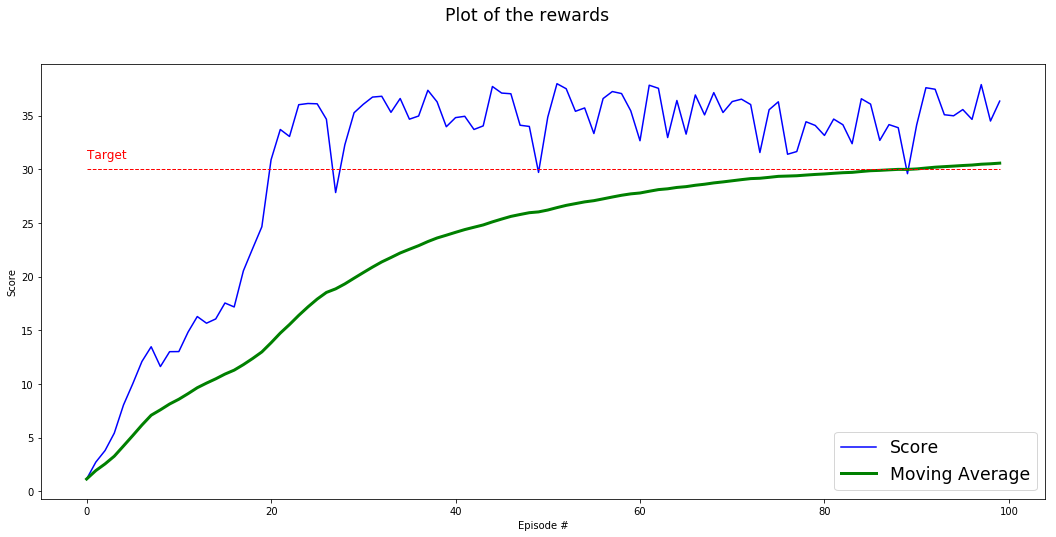

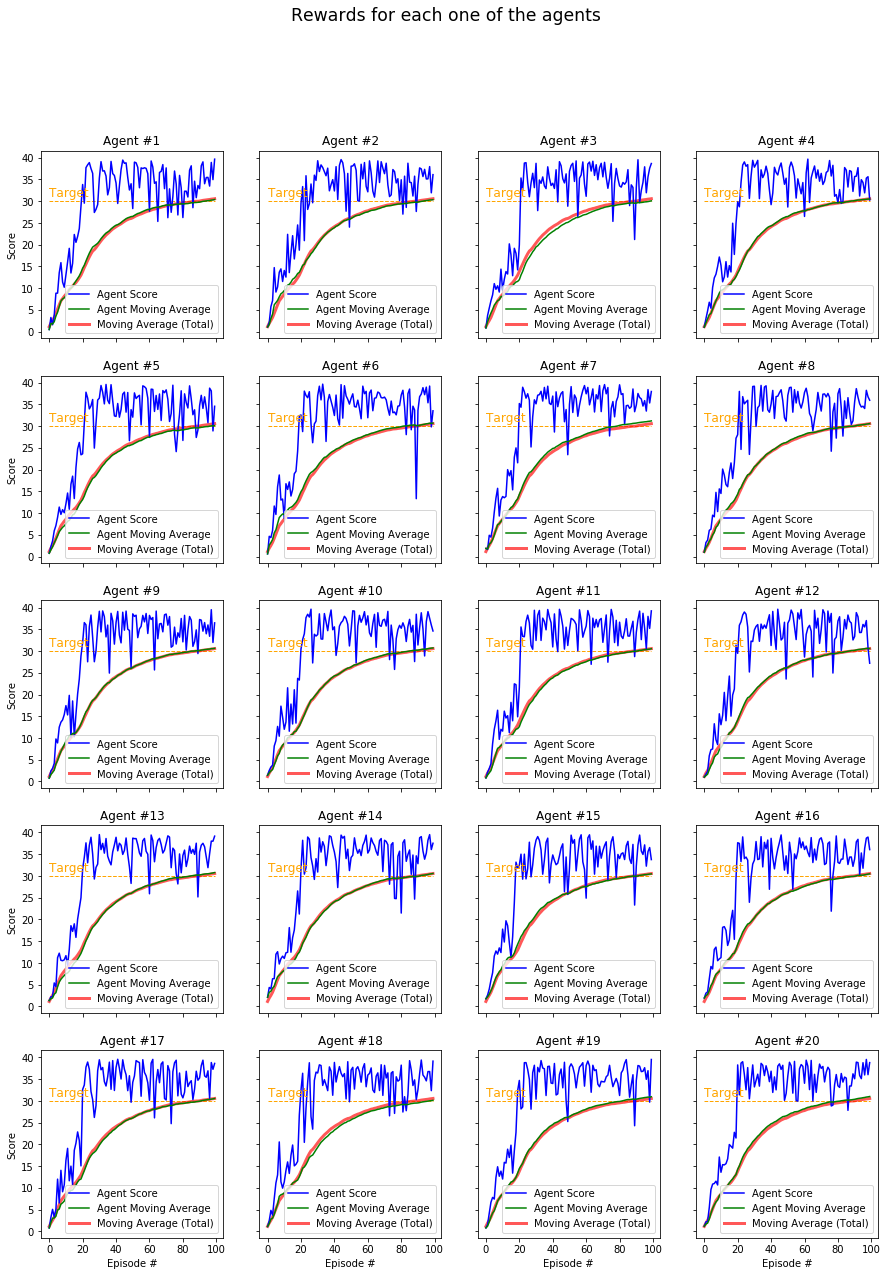

In [14]:
# Preprocess some variables
scores_mean = np.mean(scores, axis=1)
moving_average_mean = np.mean(moving_average, axis=1)
target = [_target_score] * len(scores)    # Display a line indicating the target value


# Plot the graph with the scores and moving average

fig = plt.figure(figsize=(18,8))
fig.suptitle('Plot of the rewards', fontsize='xx-large')

ax = fig.add_subplot(111)
ax.plot(scores_mean, label='Score', color='Blue')                             # Plot scores 
ax.plot(moving_average_mean, label='Moving Average', color='Green', linewidth=3)  # Plot moving average
ax.plot(target, color='Red', linestyle='--', linewidth=1)                      # Plot target line
ax.text(0, _target_score + 1, 'Target', color='Red', fontsize='large')        # Plot target line at _target_score = 30
ax.set_ylabel('Score')
ax.set_xlabel('Episode #')
ax.legend(fontsize='xx-large', loc='lower right')

plt.show()


# Plot one graph for each one of the 20 agents, if that is the case

if len(scores[0]) == 20:
    fig, axs = plt.subplots(5, 4, figsize=(15, 20), sharex=True, sharey=True)
    fig.suptitle('Rewards for each one of the agents', fontsize='xx-large')
    axs = axs.flatten()
    
    for idx, (ax, s, m) in enumerate(zip(axs, np.transpose(scores), np.transpose(moving_average))):
        ax.plot(s, label='Agent Score', color='Blue', zorder=2)                    # Plot scores
        ax.plot(m, label='Agent Moving Average', color='Green', zorder=3)          # Plot moving average for individual agent
        ax.plot(moving_average_mean, label='Moving Average (Total)', color='Red', zorder=1, linewidth=3, alpha=0.655)   # Plot moving average for total of all agents.
        ax.plot(target, linestyle='--', color='Orange', zorder=0, linewidth=1)     # Plot target line at _target_score = 30
        ax.text(0, _target_score + 1, 'Target', color='Orange', fontsize='large')
        
        ax.set_title('Agent #%d' % (idx+1))
        ax.set_ylabel('Score')
        ax.set_xlabel('Episode #')
        ax.label_outer()
        ax.legend(fontsize='medium')
    
    plt.show()


In [15]:
# Reset the environment
try:
    env
except:
    env = UnityEnvironment(file_name='Reacher_20_Linux/Reacher.x86_64')
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=False)[brain_name]
    num_agents = len(env_info.agents)
    action_size = brain.vector_action_space_size
    states = env_info.vector_observations
    state_size = states.shape[1]

In [16]:
# Load the pre-trained model
checkpoint = torch.load('checkpoint.pt', map_location='cpu')
agent = Agent(state_size, action_size, random_seed=0)

agent.actor_local.load_state_dict(checkpoint['actor_dict'])
agent.critic_local.load_state_dict(checkpoint['critic_dict'])

DDPG Agent hyperparameters:
	batch size: 		     128
	buffer_size: 		  100000
	discount / gamma: 	   0.990
	actor learning rate: 	   0.001
	critic learning rate: 	   0.001
	soft update / tau: 	   0.001
	noise decay rate: 	   0.999

Actor network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=4, bias=True)
)
Actor network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=4, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=404, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=1, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=404, out_feat

In [17]:
# Watch the agent perform in the environment

scores_episode = np.zeros(num_agents)
for i in range(1000):
    actions = agent.act(states, noise=False)
    env_info = env.step(actions)[brain_name]
    states = env_info.vector_observations
    rewards = env_info.rewards
    scores_episode += rewards
    
print('Score for this episode: {:.2f}'.format(scores_episode.mean()))

Score for this episode: 35.75


In [18]:
env.close()